Some TODOs:
- get embeddings across layers, and compare cosine distances across the target token layer-by-layer: when does the cosine distance begin to diverge?

In [1]:
%reset

import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

import torch
import transformers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

sns.set(style='whitegrid',font_scale=1.2)

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


#### set up the df of sentence pairs

In [2]:
sns.set(style='whitegrid',font_scale=1.2)

In [3]:
import itertools
import pandas as pd

def make_sentence_pairs(df):

    word_list = set(df['Word'].values)

    gather_dfs = []
    for word in word_list:

        subword = df[df['Word']==word]

        sentence_list = []
        n_senses = subword['Sense_id'].values.max()

        #append the sense id to each sentence, so
        #that later you can tell which sentences should be
        #tagged as same or different sense
        for sense in range(int(n_senses)+1):
            subsense = subword[subword['Sense_id']==str(sense)]

            for ix,row in subsense.iterrows():
                tmp = row['Sentence'] + '_' + row['Sense_id']

                sentence_list.append(tmp)

        #create all possible combinations of sentence pairs
        comb_len = len(sentence_list)
        all_combinations = []
        for n in range(2,3):
            all_combinations += list(itertools.combinations(sentence_list, n))

        #now that you have your list, you need to add a df column
        #having the same or different sense
        for i in range(len(all_combinations)):

            if all_combinations[i][0].split('_')[-1] == all_combinations[i][1].split('_')[-1]:
                sense = 'same'

            else:
                sense = 'different'

            d = {'S1': [all_combinations[i][0].split('_')[0]],
                 'S2': [all_combinations[i][1].split('_')[0]],
                 'Word': [word],
                 'Sense_Relative': [sense]
                }

            gather_dfs.append(pd.DataFrame(d))

    newdf = pd.concat(gather_dfs,ignore_index=True)

    return newdf


In [4]:
#running the below generates a df called df_pairs
%run -i 'span_rawc_inprog.py'

df = make_sentence_pairs(df_stims)

In [5]:
df.head(5)

,S1,S2,Word,Sense_Relative
0,Le gustó el canal televisivo,Le gustó el canal de comedia,canal,same
1,Le gustó el canal televisivo,Le gustó el canal del puerto,canal,different
2,Le gustó el canal televisivo,Le gustó el canal marítimo,canal,different
3,Le gustó el canal de comedia,Le gustó el canal del puerto,canal,different
4,Le gustó el canal de comedia,Le gustó el canal marítimo,canal,different


In [6]:
df = pd.read_csv("../data/raw/items/sawc_sentence_pairs.csv")

In [7]:
df.head(2)

,Word,Sentence_1,Sense_id_s1,Gender_s1,Sentence_2,Sense_id_s2,Gender_s2,context_cue1,context_cue2,Same_sense,Same_gender,counts,Tag
0,aceite,Compró el aceite de oliva,1,male,Compró el aceite de cocina,1,male,adjective,adjective,True,True,6,Compró el aceite de cocina__Compró el aceite d...
1,aceite,Compró el aceite de oliva,1,male,Compró el aceite de motor,2,male,adjective,adjective,False,True,6,Compró el aceite de motor__Compró el aceite de...


In [8]:
df.shape

(812, 13)

### testing tokenizer on target words

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [10]:
word_list = sorted(set(df['Word'].values))
print(len(word_list))

102


In [11]:
for word in word_list:
    token_ids = tokenizer.encode(word)
    
    if len(token_ids) > 3:
        print(word,":",token_ids)

compás : [4, 1327, 1134, 5]
pupila : [4, 1524, 8120, 30932, 5]
redada : [4, 6631, 1093, 5]
sirena : [4, 4110, 1746, 5]
taco : [4, 16718, 30933, 5]
tecla : [4, 2983, 1121, 5]


## Getting embeddings

In [12]:
import functools
from scipy.spatial.distance import cosine


def find_sublist_index(mylist, sublist):
    """Find the first occurence of sublist in list.
    Return the start and end indices of sublist in list

    h/t GPT-3-codex for writing this."""

    for i in range(len(mylist)):
        if mylist[i] == sublist[0] and mylist[i:i+len(sublist)] == sublist:
            return i, i+len(sublist)
    return None

@functools.lru_cache(maxsize=None)  # This will cache results, handy later...
def get_embedding(model, tokenizer, sentence, target, layer):
    """Get a token embedding for target in sentence"""
    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors="pt")
    # Tokenize target
    target_enc = tokenizer.encode(target, return_tensors="pt",
                                  add_special_tokens=False)
    # Get indices of target in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )

    # Run model
    with torch.no_grad():
        output = model(**inputs)
        hidden_states = output.hidden_states

    # Get layer
    selected_layer = hidden_states[layer][0]

    #grab just the embeddings for your target word's token(s)
    token_embeddings = selected_layer[target_inds[0]:target_inds[1]]

    #if a word is represented by >1 tokens, take mean
    #across the multiple tokens' embeddings
    embedding = torch.mean(token_embeddings, dim=0)
    return embedding

### dataset of sentence pairs

In [10]:
# df.head(40)

#### load the model you'll get embeddings for

In [24]:
model_path = "dccuchile/bert-base-spanish-wwm-cased"
model = transformers.AutoModelForCausalLM.from_pretrained(model_path,
    output_hidden_states=True  # Set this argument to True
)
model_tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)  # Load tokenizer

/Users/seantrott/anaconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


In [69]:
n_layers = 13 #figure this out from num hidden layers
results = []

for layer in range(n_layers):
    for (ix, row) in tqdm(df.iterrows(), total=df.shape[0]):

        ### Get embeddings for S1 and S2
        s1 = get_embedding(model, model_tokenizer, row['Sentence_1'], row['Word'],layer=layer)
        s2 = get_embedding(model, model_tokenizer, row['Sentence_2'], row['Word'],layer=layer)

        ### Now calculate cosine distance
        model_cosine = cosine(s1, s2)

        ### Figure out how many tokens you're
        ### comparing across sentences
        n_tokens_s1 = len(tokenizer.encode(row['Sentence_1']))
        n_tokens_s2 = len(tokenizer.encode(row['Sentence_1']))

        ### Add to results dictionary
        results.append({
            'Sentence_1': row['Sentence_1'],
            'Sentence_2': row['Sentence_2'],
            'Word': row['Word'],
            'Same_sense': row['Same_sense'],
            'Distance': model_cosine,
            'Layer': layer,
            'S1_ntokens': n_tokens_s1,
            'S2_ntokens': n_tokens_s2
        })

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

In [70]:
df_results = pd.DataFrame(results)
df_results['token_diffs'] = np.abs(df_results['S1_ntokens'].values-df_results['S2_ntokens'].values)


In [71]:
df_results.to_csv("../data/processed/models/sawc_distances.csv", index=False)

### Analyzing

In [3]:
df_results = pd.read_csv("../data/processed/models/sawc_distances.csv")
df_results.shape

(10556, 9)

In [5]:
n_layers = 13

In [6]:
gdf = df_results.groupby('token_diffs').count().reset_index()

#the same sentence pair is evaluated across all layers--
#avoid counting the sentence pairs over and over for
#every layer by dividing the number of df rows by the
#number of model layers
gdf['n_sentence_pairs'] = gdf['Distance'].values/n_layers

In [7]:
gdf

,token_diffs,Sentence_1,Sentence_2,Word,Same_sense,Distance,Layer,S1_ntokens,S2_ntokens,n_sentence_pairs
0,0,10556,10556,10556,10556,10556,10556,10556,10556,812.0


In [8]:
df_results.shape

(10556, 9)

### check the difference in number of tokens across sentence stims

I don't know if the embedding for the target ambiguous word will differ in large or small ways as a function of differences in tokenization of the *contextual cues* (e.g. `asado` v. `juguetón`), so I am counting here the number of sentence pairs that have either no difference in number of tokens per sentence (0) or a non-zero difference in the number of tokens per sentence (>1).

Text(0.5, 1.0, 'differences in tokenization for sentence pairs')

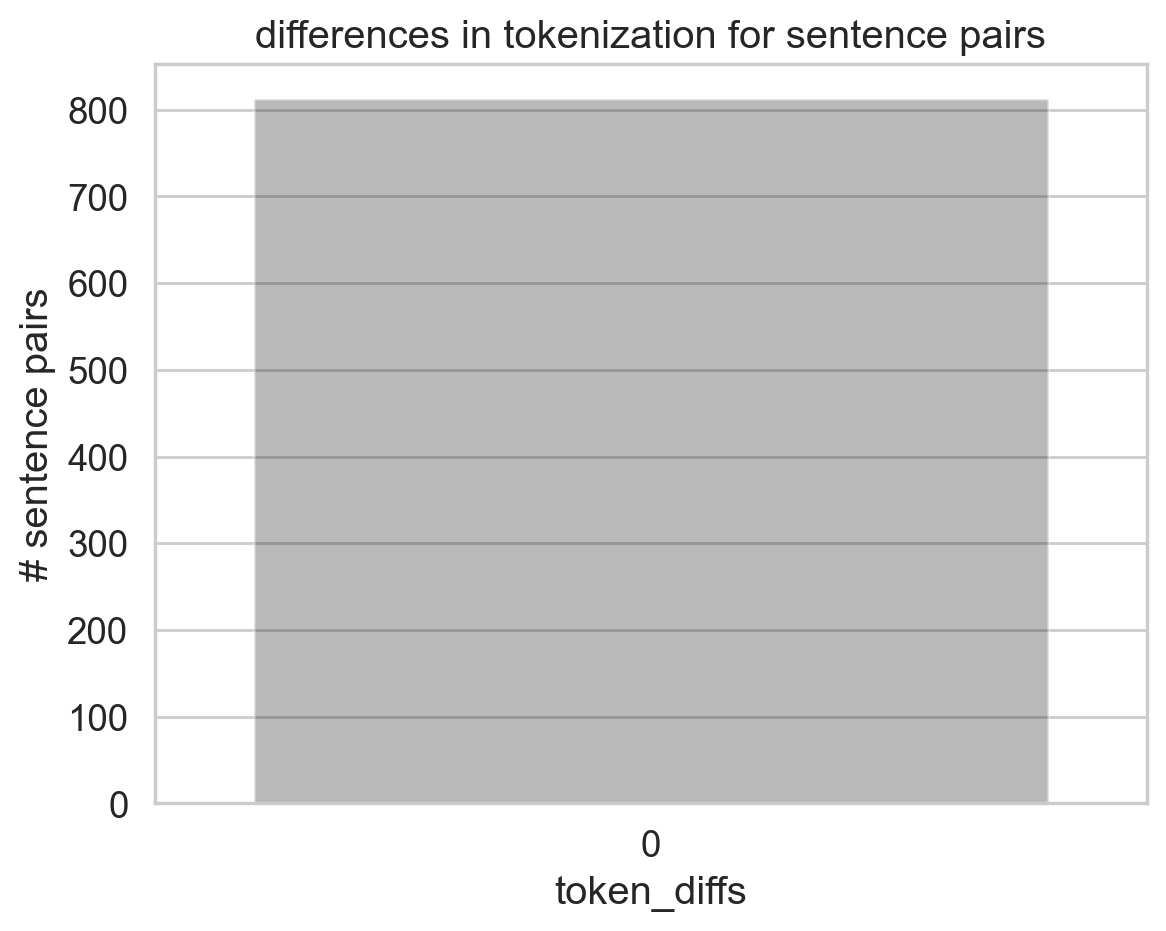

In [87]:
token_diffs = df_results['S1_ntokens'].values-df_results['S2_ntokens'].values

sns.barplot(data=gdf,
            x='token_diffs',
            y='n_sentence_pairs',
            color='k',
            alpha=0.3)
plt.ylabel('# sentence pairs')
plt.title('differences in tokenization for sentence pairs')

Does the difference in number of tokens representing each sentence correlate with the cosine distance between the target word embeddings derived from each sentence?

In [88]:
sns.set(style='whitegrid',font_scale=1.7)

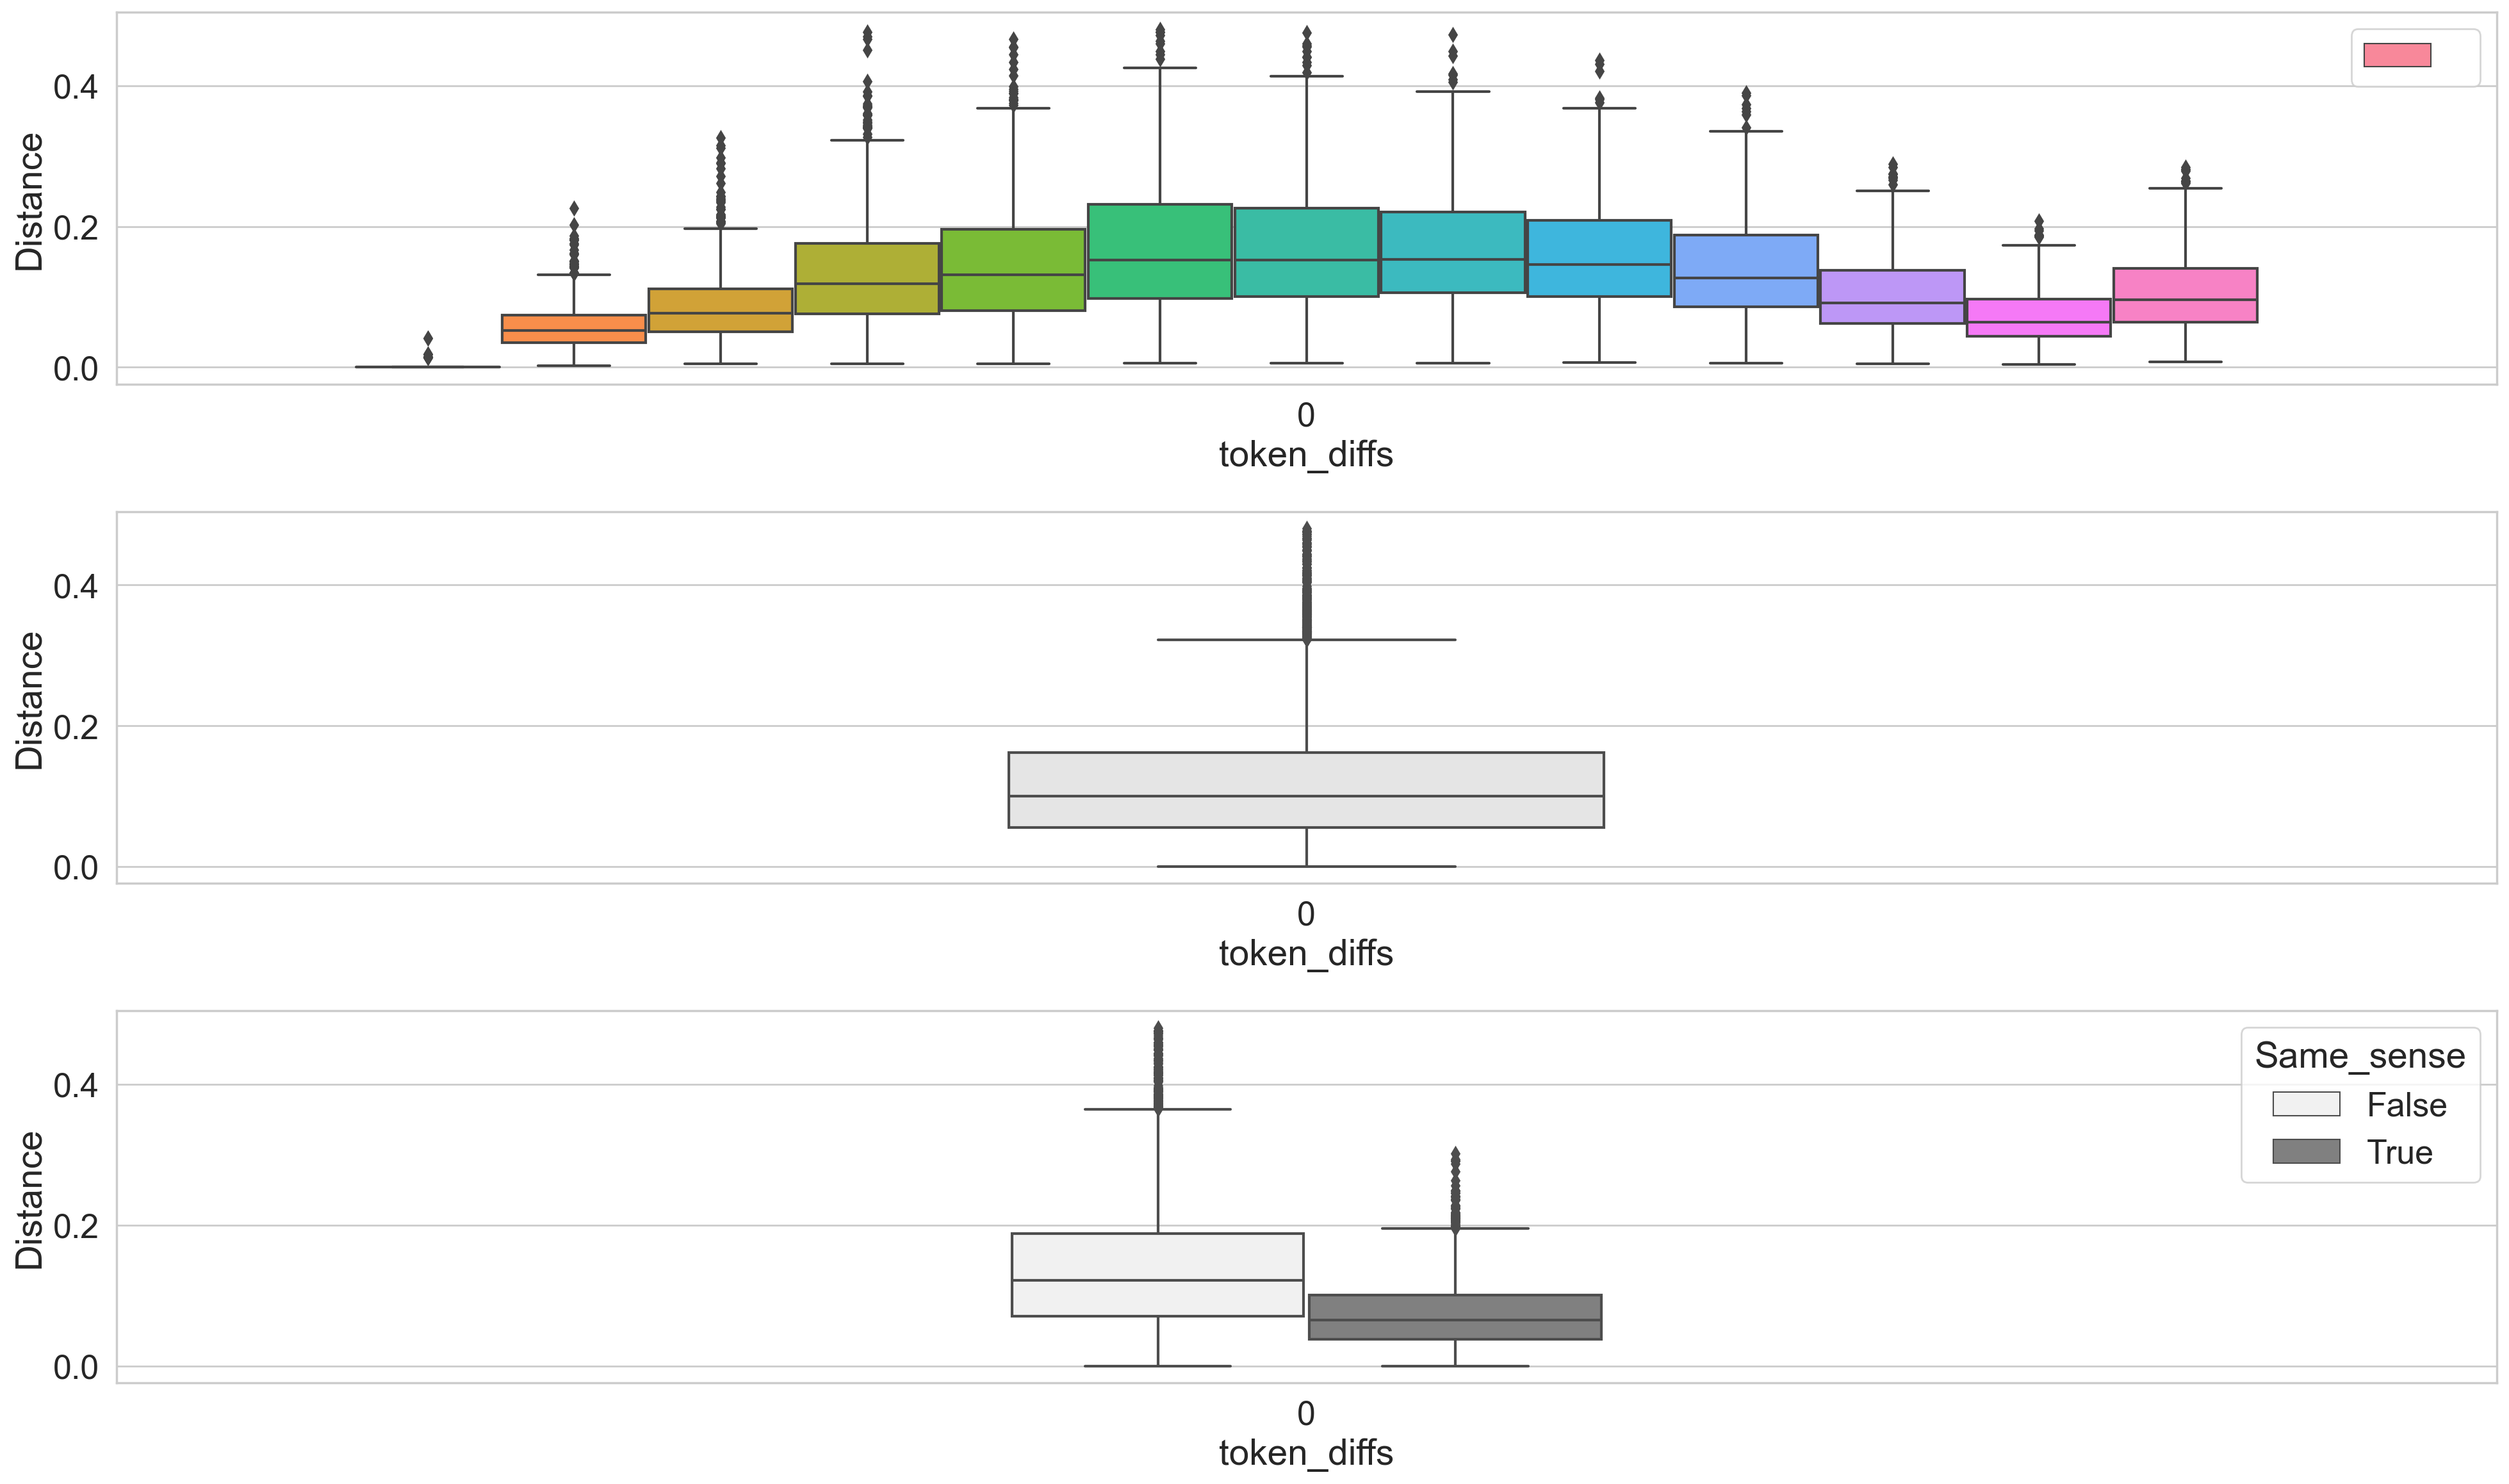

In [89]:
fig, ax = plt.subplots(3,1,figsize=(20,12))

sns.boxplot(data=df_results,
            x='token_diffs',
            y='Distance',
            hue='Layer',
            saturation=1,
            ax=ax[0]
           )

ax[0].legend(' ')

sns.boxplot(data=df_results,
            x='token_diffs',
            y='Distance',
            color='grey',
            saturation=1,
            width=0.25,
            boxprops={"facecolor": (.8, .8, .8, .5)},
            ax=ax[1]
           )

sns.boxplot(data=df_results,
            x='token_diffs',
            y='Distance',
            color='grey',
            saturation=1,
            width=0.25,
            hue='Same_sense',
            ax=ax[2]
           )

fig.tight_layout()


### question:
What do we do now that there are more sentence pairs for "Different" (4) than "Same" (2) sense per word? Are distance metrics for "Different" getting unfair advantage over "Same", in terms of the variance in the distribution of cosine distances per sentence pair?

Text(0.5, 1.0, 'cosine distances \n n_wordforms = 102 n_pairs = 812')

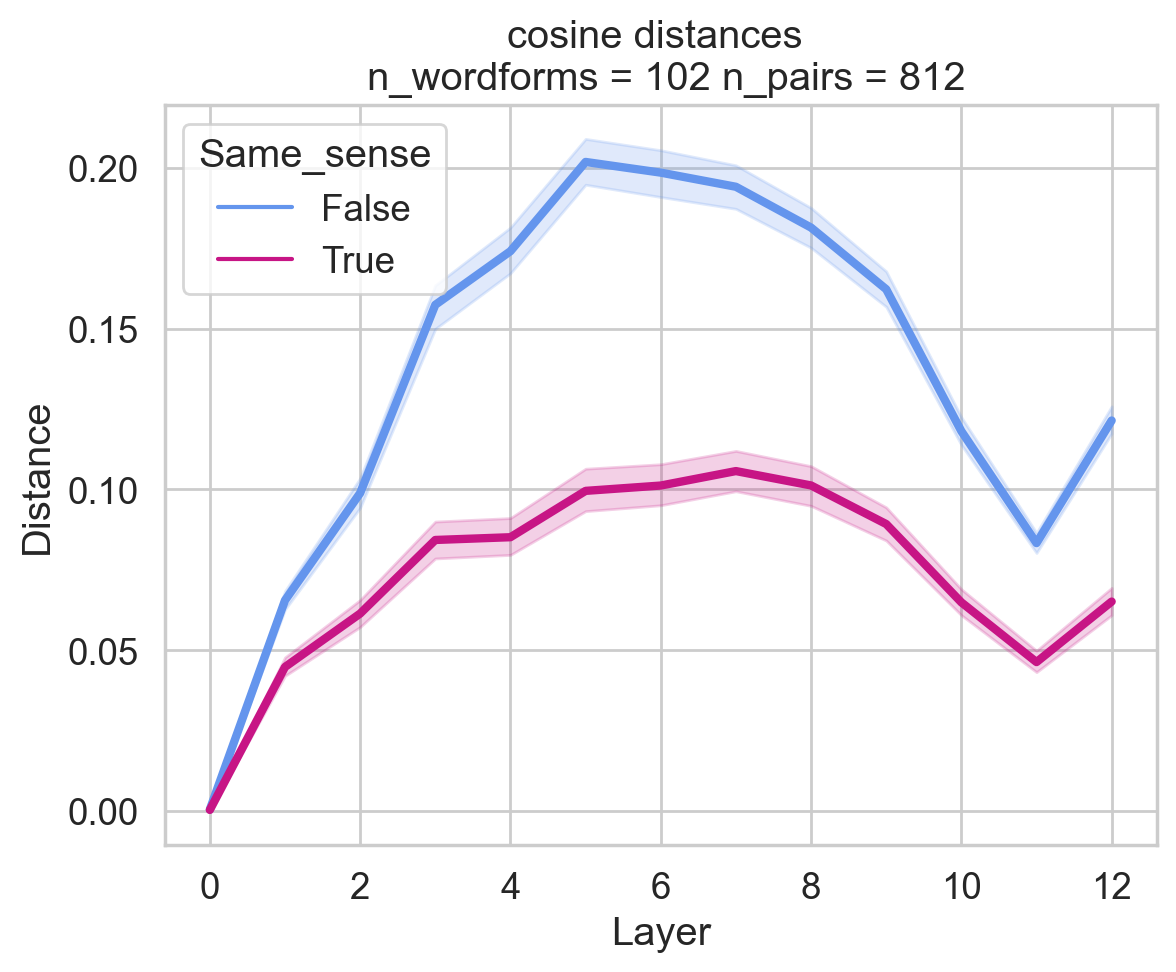

In [90]:
sns.set(style='whitegrid',font_scale=1.2)
n_wordforms = len(word_list)
n_pairs = df.shape[0]

#visualize cosine distances layer by layer
sns.lineplot(data=df_results,
             x='Layer',
             y='Distance',
             hue='Same_sense',
             palette=['cornflowerblue','mediumvioletred'],
             linewidth=3
            )

#uncomment below to plot the distances for a single word
# target = 'título'
# sub = df_results[df_results['Word']==target]
# g = sns.scatterplot(data=sub,
#                     x='Layer',
#                     y='Distance',
#                     hue='Sense',
#                     palette=['navy','palevioletred'],
#                     alpha=0.6
#                    )

# sns.move_legend(g,'upper left',bbox_to_anchor=(1,1))


plt.title('cosine distances \n n_wordforms = '+str(n_wordforms) + ' n_pairs = ' + str(n_pairs))

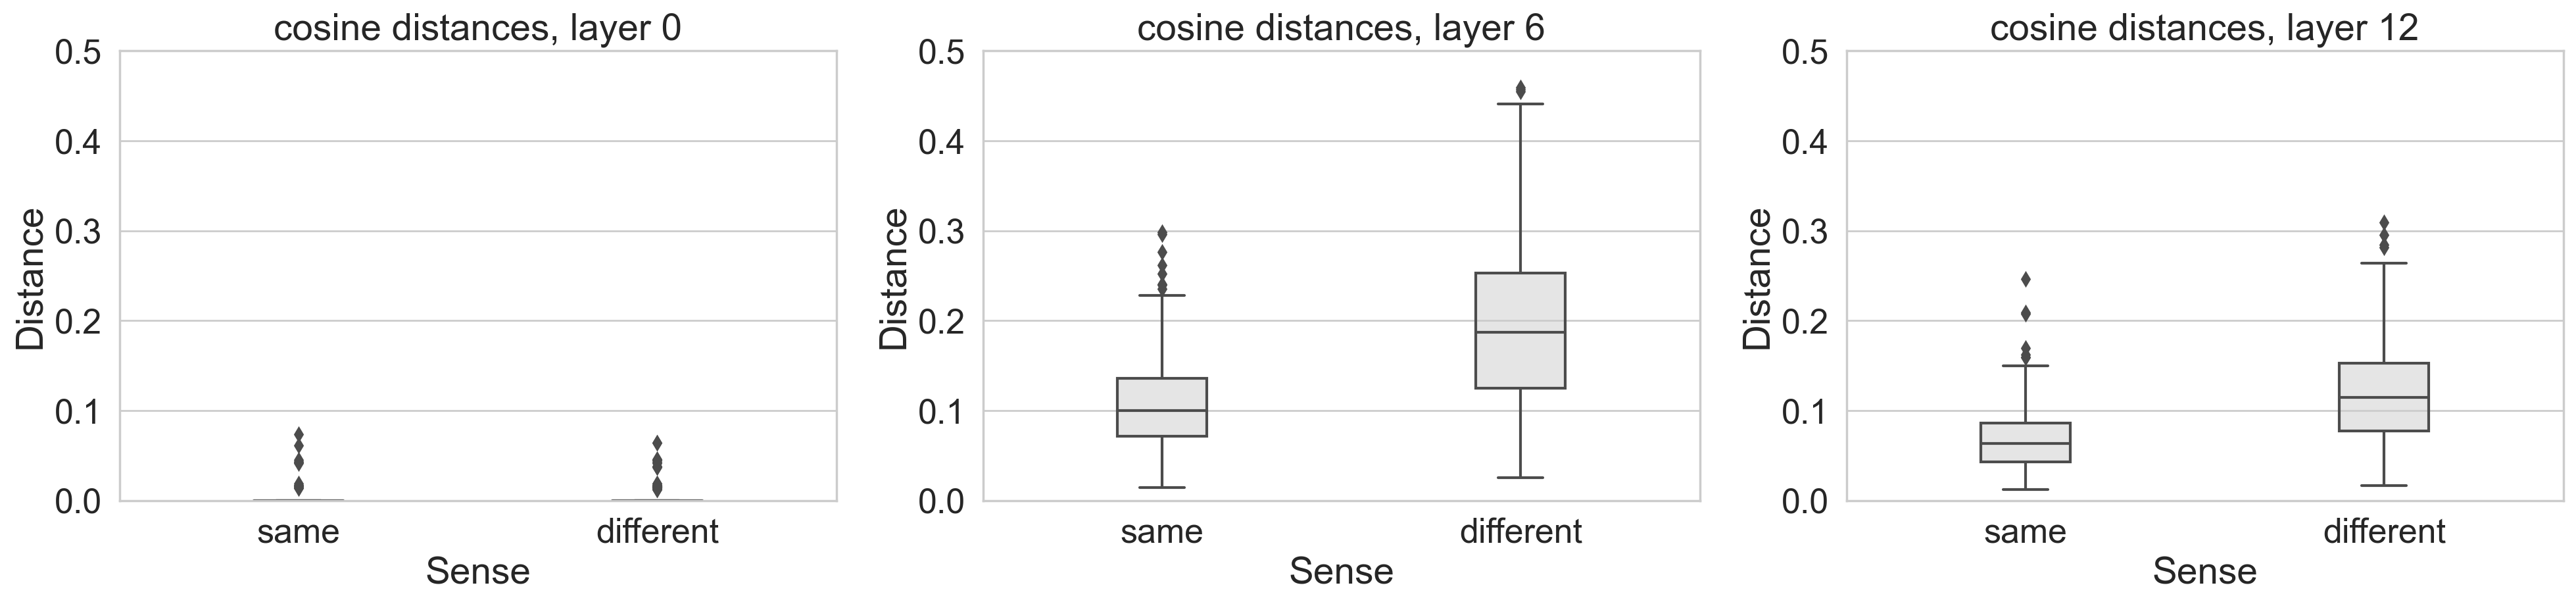

In [35]:
sns.set(style='whitegrid',font_scale=1.7)
### visualize the distance for a given layer
fig,ax = plt.subplots(1,3,figsize=(20,5))

layer = 0
sublay = df_results[df_results['Layer']==layer]
sns.boxplot(data = sublay,
            x = "Sense",
            y = "Distance",
            saturation=1,
            width=0.25,
            boxprops={"facecolor": (.8, .8, .8, .5)},
            ax=ax[0]
           )

ax[0].set_title('cosine distances, layer '+str(layer))
ax[0].set_ylim(0,0.5)

layer = 6
sublay = df_results[df_results['Layer']==layer]
sns.boxplot(data = sublay,
            x = "Sense",
            y = "Distance",
            saturation=1,
            width=0.25,
            boxprops={"facecolor": (.8, .8, .8, .5)},
            ax=ax[1]
           )

ax[1].set_title('cosine distances, layer '+str(layer))
ax[1].set_ylim(0,0.5)

layer = 12
sublay = df_results[df_results['Layer']==layer]
sns.boxplot(data = sublay,
            x = "Sense",
            y = "Distance",
            saturation=1,
            width=0.25,
            boxprops={"facecolor": (.8, .8, .8, .5)},
            ax=ax[2]
           )

ax[2].set_title('cosine distances, layer '+str(layer))
ax[2].set_ylim(0,0.5)

fig.tight_layout()



## Merge with ratings

In [70]:
import statsmodels.formula.api as smf

In [71]:
import scipy.stats as ss

In [72]:
df_sawc = pd.read_csv("../data/processed/human/sawc_relatedness_pilot.csv")
df_sawc.head(2)

,Word,Sentence_1,Sentence_2,Same_sense,Sense_id_s1,Sense_id_s2,Gender_s1,Gender_s2,Response
0,aceite,Compró el aceite de cocina,Compró el aceite de motor,False,1.0,2.0,male,male,2.666667
1,aceite,Compró el aceite de motor,Compró el aceite de carro,True,2.0,2.0,male,male,4.500000


In [73]:
df_results_subset = df_results[['Sentence_1', 'Sentence_2', 'Distance']]

In [74]:
df_merged = pd.merge(df_results, df_sawc)
df_merged.shape

(6253, 14)

In [75]:
corr_results = []
for layer in range(0, 13):
    

    df_tmp = df_merged[df_merged['Layer']==layer]
    
    mod = smf.ols(data = df_tmp, formula = "Response ~ Distance").fit()
    
    r = ss.pearsonr(df_tmp['Distance'], df_tmp['Response'])
    
    corr_results.append({
        'rsquared': mod.rsquared,
        'layer': layer
    })

In [76]:
df_corr_results = pd.DataFrame(corr_results)

<Axes: xlabel='layer', ylabel='rsquared'>

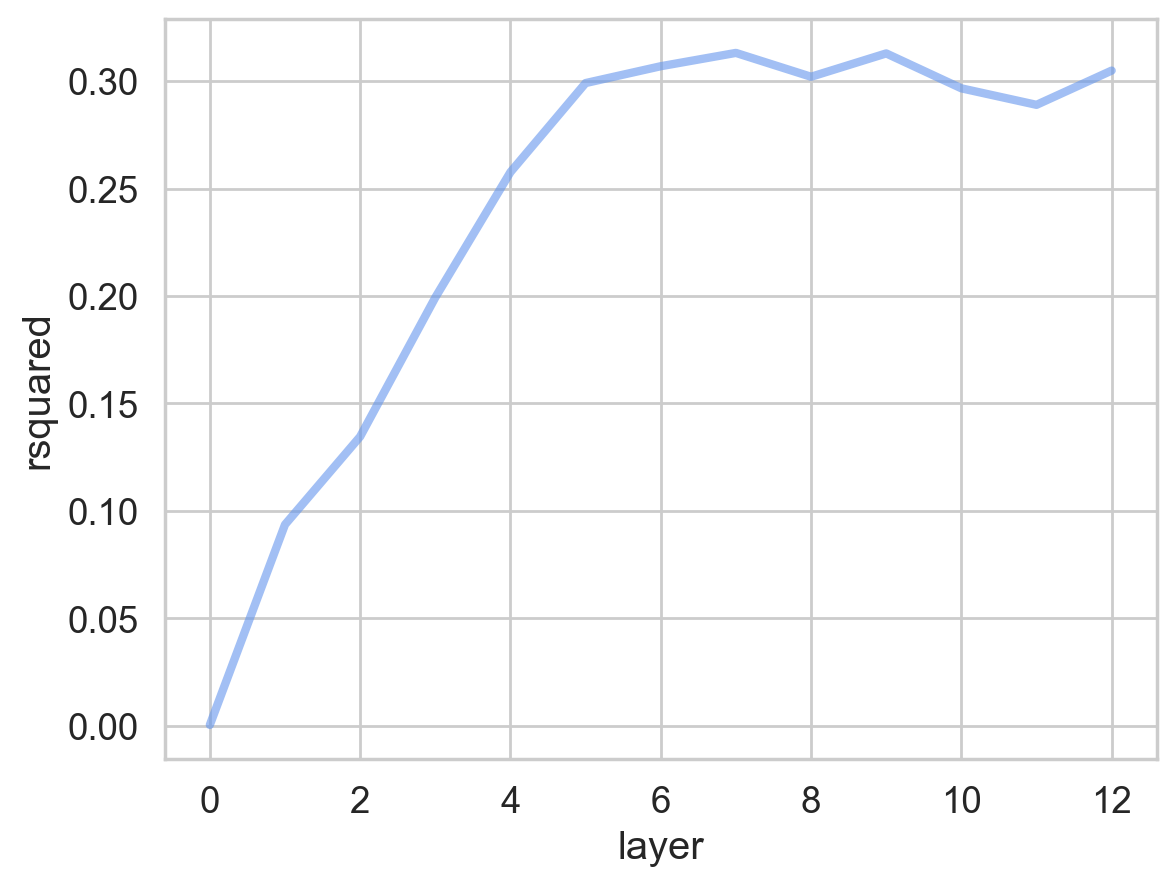

In [77]:
sns.lineplot(data = df_corr_results, 
              x = "layer", y = "rsquared",
              color='cornflowerblue',
             linewidth=3,
             alpha=0.6)

#### Trying to implement Tenney et al. (2019)

Expected layer calculation:

$\Large \bar{E}_\Delta[\ell] = \frac{\sum_{\ell=1}^L\ell*\Delta_T^{\ell}}{\sum_{\ell=1}^L\Delta_T^{\ell}}$

Where:

$\Delta_T^{\ell_i} = Score(\ell_i) - Score(\ell_{i-1})$

In [78]:
### First, calculate difference in R^2 between each subsequent layer
df_corr_results['delta'] = df_corr_results['rsquared'].diff()

In [79]:
### Now, calculate "expected layer"
num = (df_corr_results['layer'] * df_corr_results['delta']).sum()
denom = df_corr_results['delta'].sum()

e = num/denom
e

2.8033296916424923

### Classifier

In [59]:
#### Sean testing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import svm,linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

# logreg = linear_model.LogisticRegression()

logreg = linear_model.LogisticRegression(class_weight = "balanced")

In [102]:
classifier_results = []

for layer in range(0, 13):
    
    df_tmp = df_results[df_results['Layer'] == layer]
    
    X = df_tmp['Distance'].values
    y = df_tmp['Same_sense'].values
    
    y_pred = cross_val_predict(logreg,
                              X.reshape(-1,1),
                              y.ravel(),
                               # method='predict_proba',
                              cv = 10)
    
    # ll = log_loss(y, probs)
    accuracy = accuracy_score(y, y_pred)
    
    classifier_results.append({
        'layer': layer,
        'accuracy': accuracy
    })

In [103]:
df_classifier_results = pd.DataFrame(classifier_results)
df_classifier_results.head(3)

,layer,accuracy
0,0,0.311576
1,1,0.603448
2,2,0.633005


In [85]:
# baseline_5050 = log_loss(y, [[.5, .5]] * len(y))
# baseline_5050

0.6931471805599452

In [104]:
# baseline_majority = log_loss(y, [[.68, .32]] * len(y))
# baseline_majority

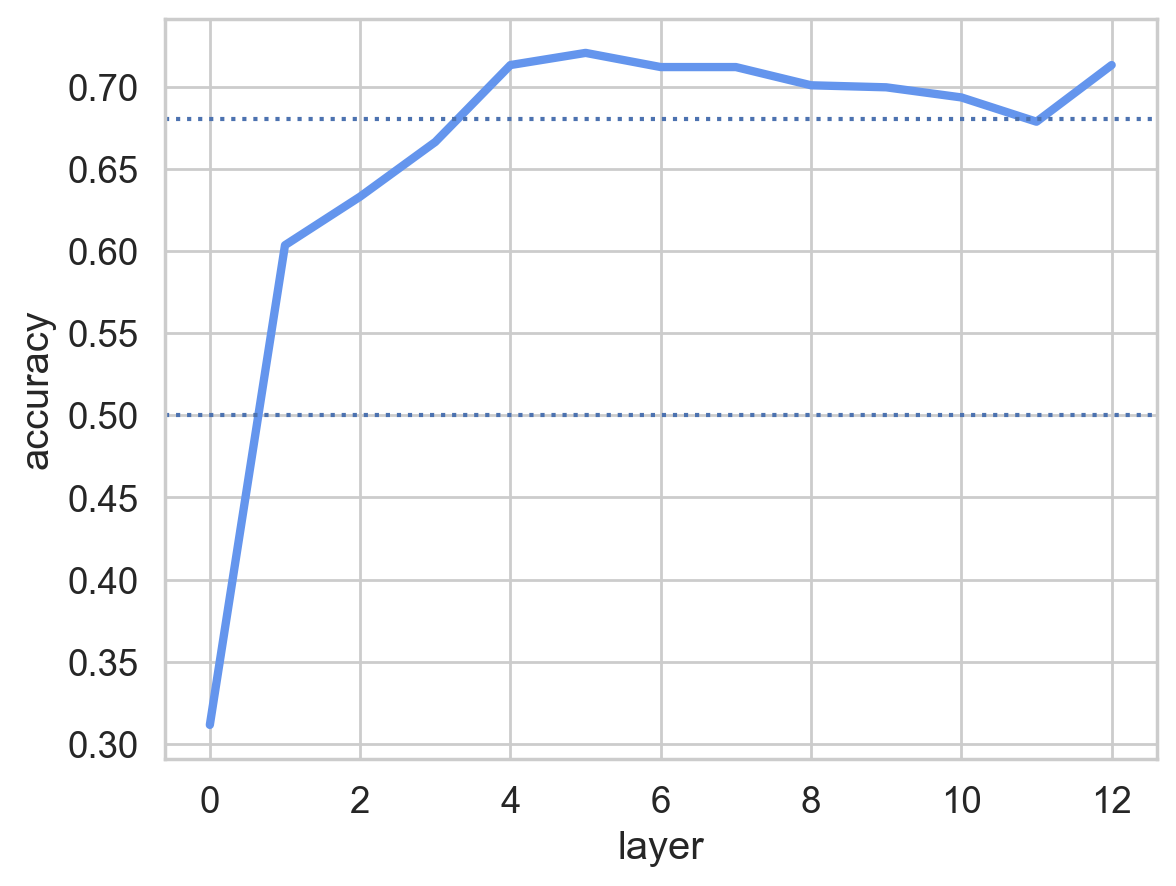

In [106]:
sns.lineplot(data = df_classifier_results, 
             x = "layer", 
             y = "accuracy",
            linewidth=3,
            color="cornflowerblue")

# plt.axhline(y = baseline_5050, linestyle = "dotted")
# plt.axhline(y = baseline_majority, linestyle = "dotted")

plt.axhline(y = .5, linestyle = "dotted")
plt.axhline(y = .68, linestyle = "dotted")

#### Trying to implement Tenney et al. (2019)

Tenney et al. (2019) do this as follows: 

$\bar{E}_\Delta[\ell] = \frac{\sum_{\ell=1}^L\ell*\Delta_T^{\ell}}{\sum_{\ell=1}^L\Delta_T^{\ell}}$

Where:

$\Delta_T^{\ell_i} = Score(\ell_i) - Score(\ell_{i-1})$


In [107]:
### First, calculate difference in log loss between each subsequent layer
df_classifier_results['delta'] = df_classifier_results['accuracy'].diff()

In [109]:
### Now, calculate "expected layer"
num = (df_classifier_results['layer'] * df_classifier_results['delta']).sum()
denom = df_classifier_results['delta'].sum()

e = num/denom
e

1.7760736196319018

## Trying out individual words

In [47]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [48]:
df_sawc_sentences = pd.read_csv("../data/raw/items/sawc_stimlist.csv")
df_sawc_sentences.shape

(451, 5)

In [49]:
word_counts = df_sawc_sentences['Word'].value_counts()
df_sawc_sentences['count'] = df_sawc_sentences['Word'].apply(lambda x: word_counts[x])

In [77]:
words = set(df_sawc_sentences['Word'].values)
len(words)

102

In [102]:
clf = RandomForestClassifier()

In [103]:
### All layers
results = []
for layer in range(0, 13):
    for word in tqdm(words):

        df_tmp = df_sawc_sentences[df_sawc_sentences['Word']==word]

        ### Now, get embeddings
        X = []
        for index, row in df_tmp.iterrows():
            e = get_embedding(model, model_tokenizer, row['Sentence'], row['Word'],layer=layer)
            X.append(e)

        ### Labels
        y = df_tmp['Sense_id']

        ### Now, fit rf
        y_pred = cross_val_predict(clf, X, y, cv = 2)

        ### Now measure
        results.append({
            'word': word,
            'layer': layer,
            'accuracy': accuracy_score(y, y_pred),
            'classes': len(set(y)),
            'n': len(y)
        })

  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/seantrott/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


In [104]:
df_wsd_results = pd.DataFrame(results)

In [105]:
df_wsd_results['accuracy'].mean()

0.6950100553041729

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Word Sense Disambiguation Accuracy')

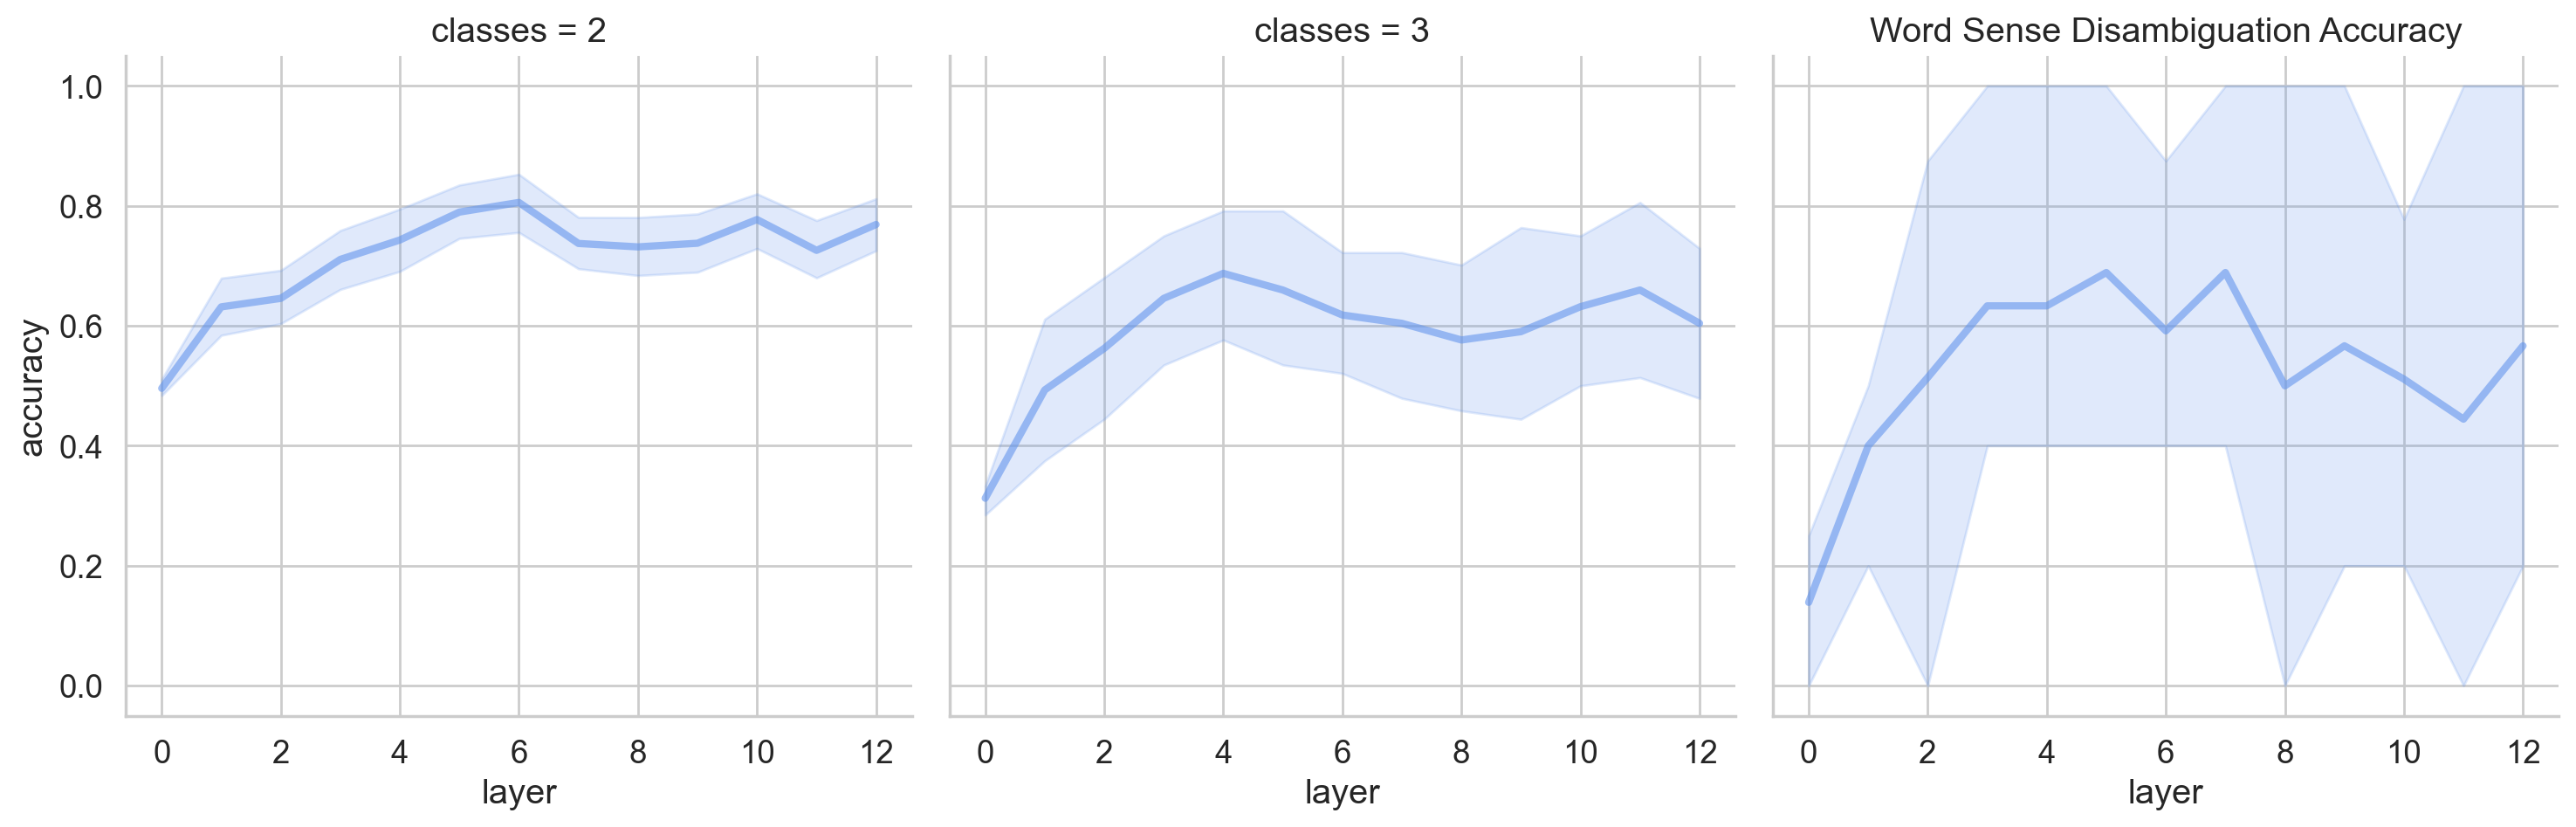

In [130]:
sns.relplot(data = df_wsd_results, 
            x = "layer", 
            y = "accuracy",
            col = "classes",
            color='cornflowerblue',
            kind = 'line',
            linewidth=3,
            alpha=0.6)
plt.title("Word Sense Disambiguation Accuracy")

Text(0.5, 1.0, 'WSD Accuracy (2 classes only)')

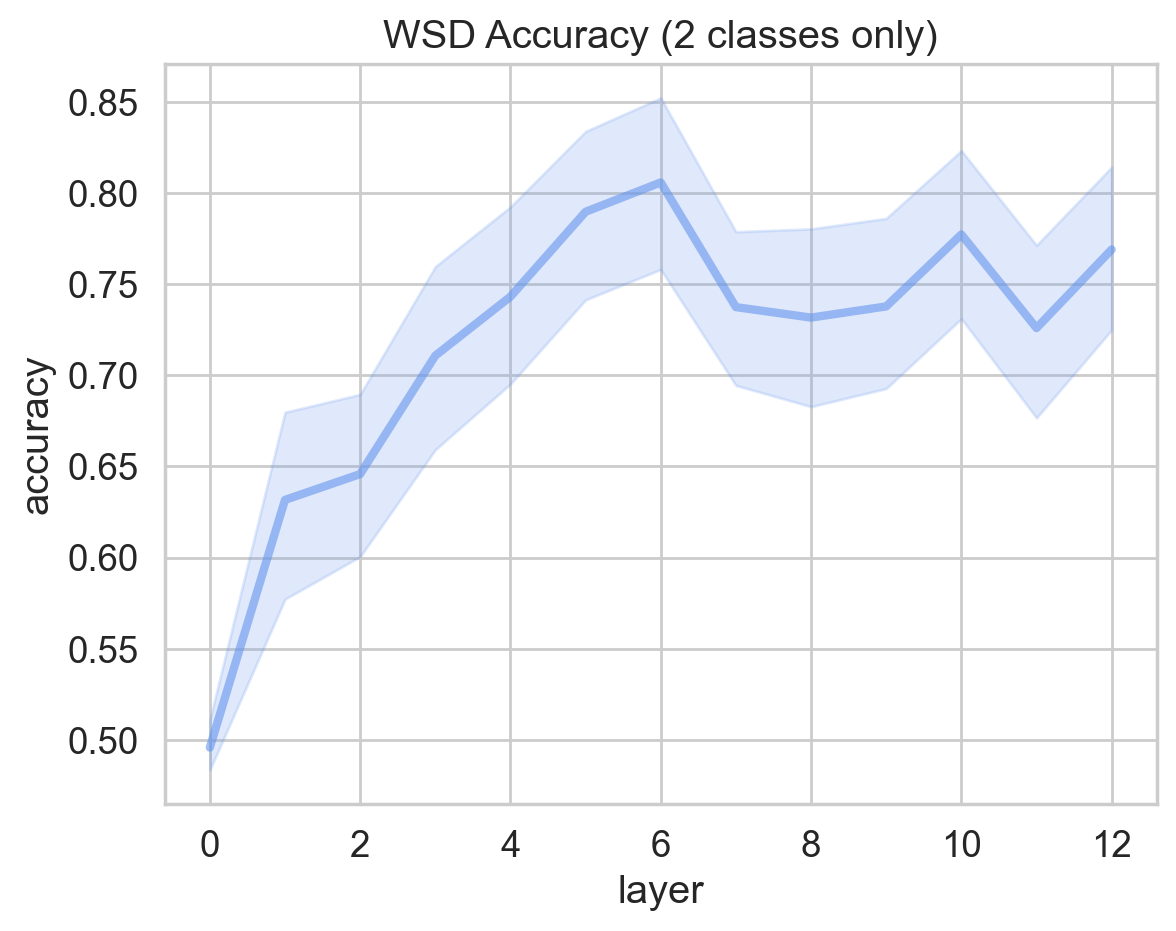

In [132]:
sns.lineplot(data = df_wsd_results[df_wsd_results['classes']<=2], 
            x = "layer", 
            y = "accuracy",
            # hue = "classes",
            color='cornflowerblue',
            linewidth=3,
            alpha=0.6)
plt.title("WSD Accuracy (2 classes only)")

#### Trying to implement Tenney et al. (2019)

Expected layer calculation:

$\Large \bar{E}_\Delta[\ell] = \frac{\sum_{\ell=1}^L\ell*\Delta_T^{\ell}}{\sum_{\ell=1}^L\Delta_T^{\ell}}$

Where:

$\Delta_T^{\ell_i} = Score(\ell_i) - Score(\ell_{i-1})$

In [133]:
df_wsd_results_by_layer = df_wsd_results[df_wsd_results['classes']==2].groupby("layer").mean("accuracy").reset_index()

Text(0.5, 1.0, 'Word Sense Disambiguation Accuracy')

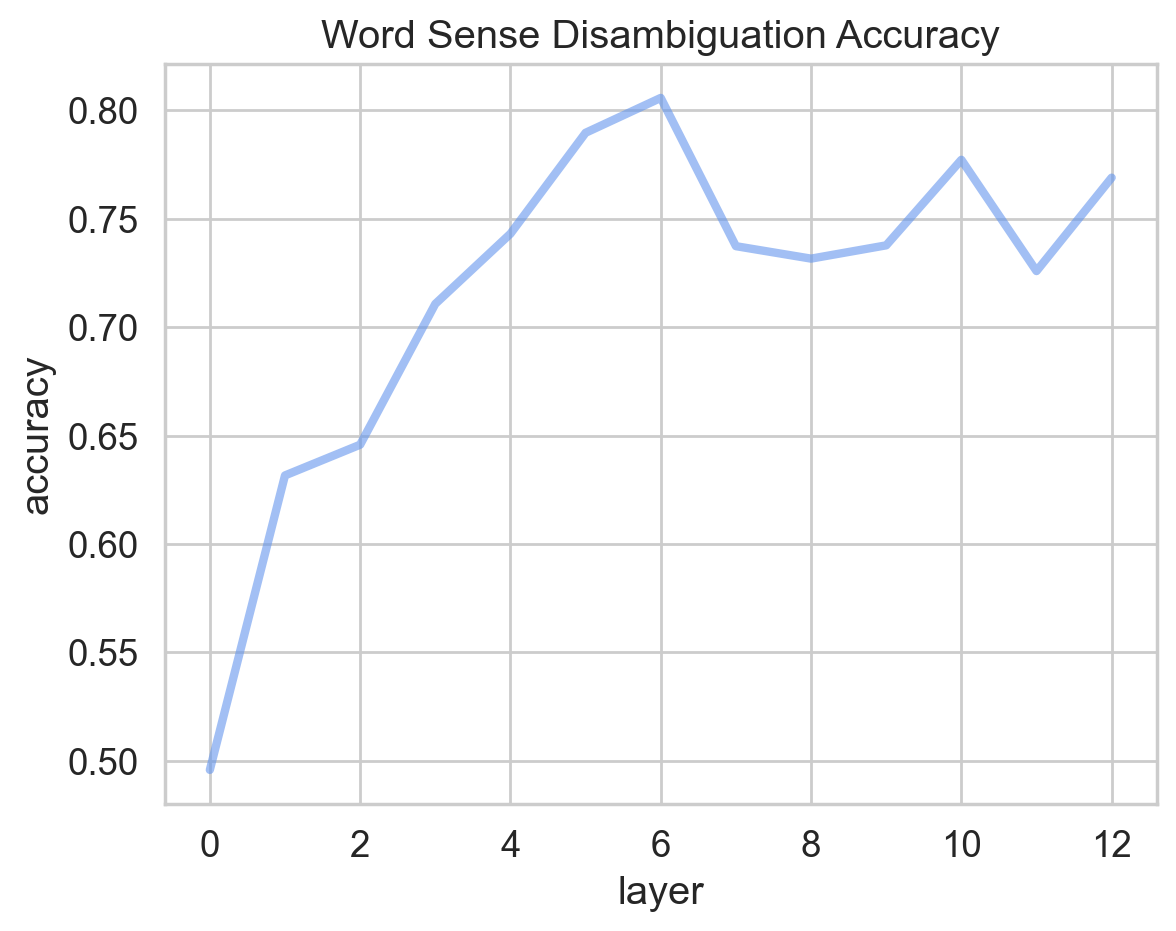

In [134]:
sns.lineplot(data = df_wsd_results_by_layer, 
            x = "layer", 
            y = "accuracy",
            # hue = "classes",
            color='cornflowerblue',
            linewidth=3,
            alpha=0.6)
plt.title("Word Sense Disambiguation Accuracy")

In [135]:
### First, calculate difference in accuracy between each subsequent layer
df_wsd_results_by_layer['delta'] = df_wsd_results_by_layer['accuracy'].diff()

In [136]:
### Now, calculate "expected layer"
num = (df_wsd_results_by_layer['layer'] * df_wsd_results_by_layer['delta']).sum()
denom = df_wsd_results_by_layer['delta'].sum()

e = num/denom
e

2.5455820476858375

## set up a classifier (linear probe?)

To classify target word embeddings derived from a given layer into 'same' or 'different' sense categories.

Tenney et al. : "We would like to estimate at which layer in the encoder a target (s1,s2,label) can be correctly predicted"

[Tenney et al. (2019) ICLR](https://openreview.net/pdf?id=SJzSgnRcKX) might have the classifier specification?


**first:** compute and save the embeddings for all the target words and their corresponding senses (so the number of embeddings equals the number of sentences) for a given layer (we'll be training one classifier per layer, to see at which layer the context-based distinctions begin to emerge)


In [26]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import svm,linear_model

In [ ]:
results = []
for layer in range(n_layers):

    embeddings = []
    model_cosines = []
    y = []

    for (ix, row) in tqdm(df.iterrows(), total=df.shape[0]):

        ### Get embeddings for S1 and S2
        s1 = get_embedding(model, model_tokenizer, row['S1'], row['Word'],layer=layer)
        s2 = get_embedding(model, model_tokenizer, row['S2'], row['Word'],layer=layer)

        ### Concatenate and store target word embeddings
        embeddings.append(np.hstack((s1,s2)))

        ### Now calculate cosine distance
        model_cosines.append(cosine(s1, s2))

        ### Turn the Sense_Relative var into numerical
        # code
        if row['Sense_Relative'] == 'same':
            y.append(0)

        elif row['Sense_Relative'] == 'different':
            y.append(1)

    ### Sean's pseudocode
    y = np.asarray(y) # same vs. different (target)
    X1 = np.asarray(model_cosines)
    X2 = np.asarray(embeddings)

    ### Fit your models
    logreg = linear_model.LinearRegression()
    score_lr = np.mean(cross_val_score(logreg, X1.reshape(-1,1), y.reshape(-1,1), cv = 5,error_score='raise'))

    svmach = svm.SVC()
    score_svm = np.mean(cross_val_score(svmach, X2, y, cv = 5,error_score='raise'))

    d = {'layer': [layer],
         'score_cosd_logreg': [score_lr],
         'score_embed_svm': [score_svm]
        }
    results.append(pd.DataFrame(d))

clf_results = pd.concat(results)

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

  0%|          | 0/711 [00:00<?, ?it/s]

In [ ]:
clf_results

,layer,score_cosd_logreg,score_embed_svm
0,0,-0.002621,0.658278
0,1,0.049651,0.658278
0,2,0.078934,0.658278
0,3,0.119514,0.661076
0,4,0.164085,0.661076
0,5,0.185651,0.665291
0,6,0.189421,0.673732
0,7,0.180864,0.677938
0,8,0.167959,0.680735
0,9,0.167557,0.680735


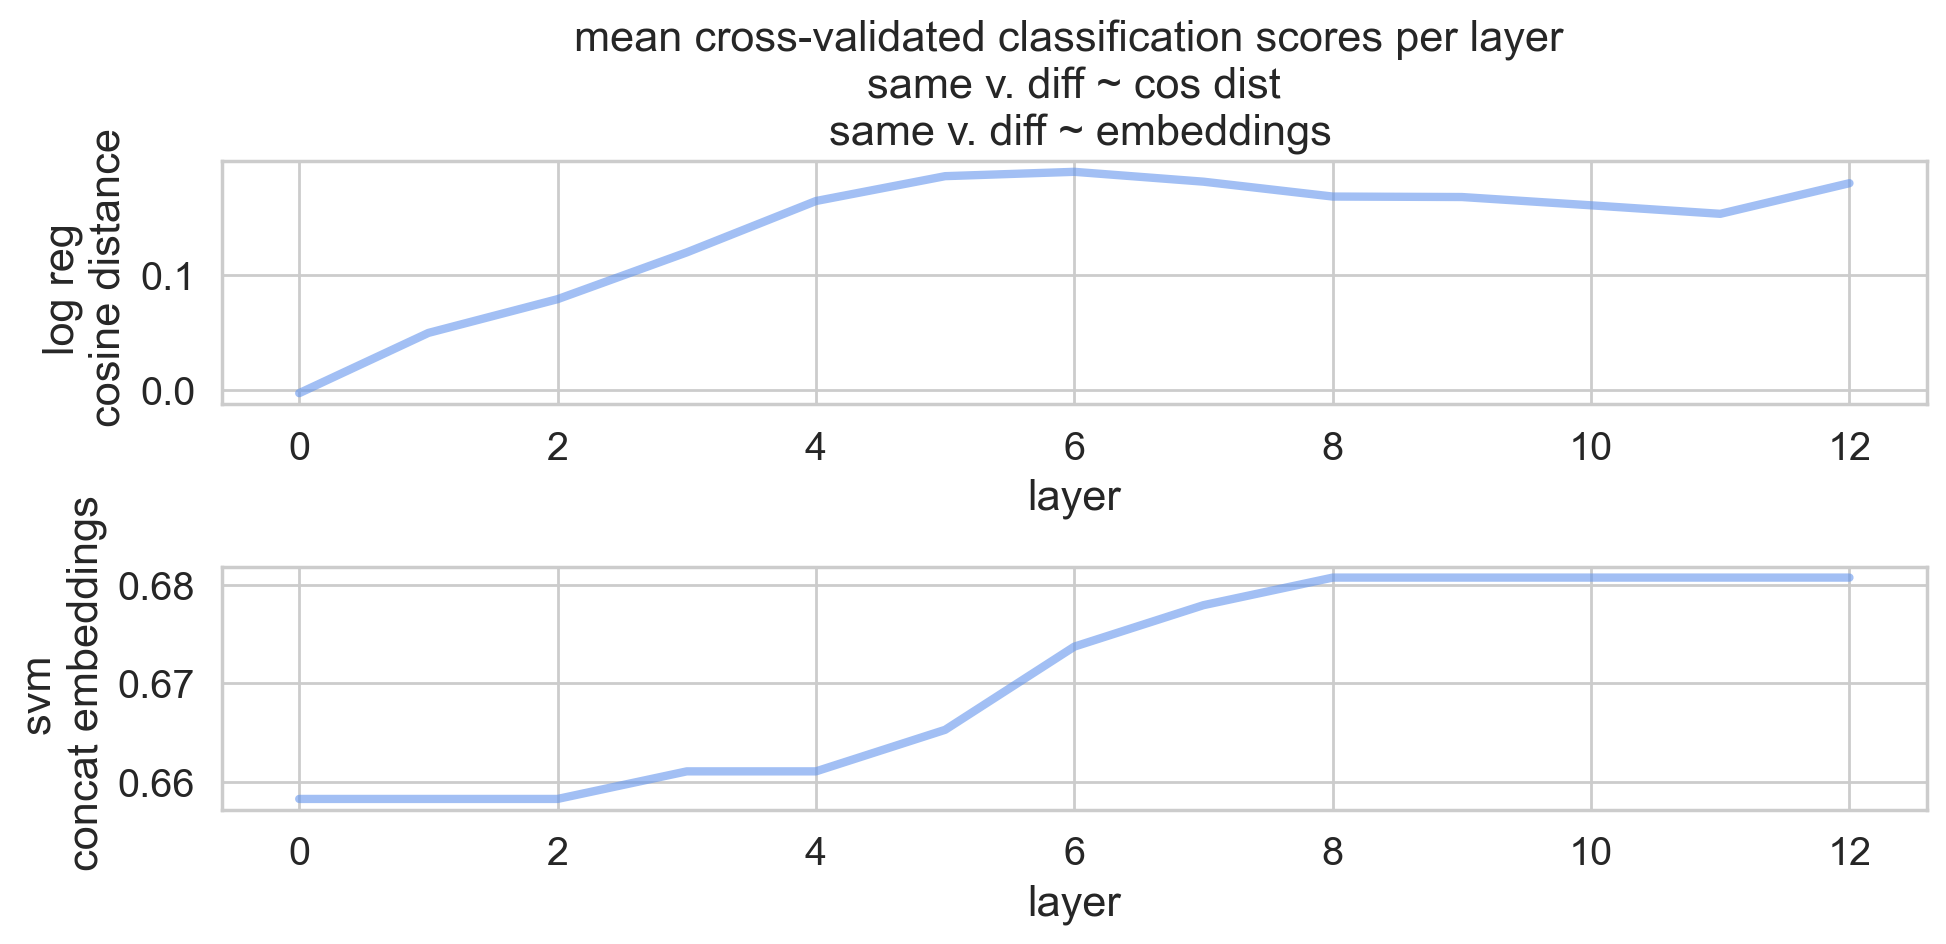

In [ ]:
sns.set(style='whitegrid',font_scale=1.3)
fig,ax = plt.subplots(2,1,figsize=(10,5))
#visualize cosine distances layer by layer
sns.lineplot(data=clf_results,
             x='layer',
             y='score_cosd_logreg',
             color='cornflowerblue',
             linewidth=3,
             alpha=0.6,
             ax=ax[0]
            ).set_title('mean cross-validated classification scores per layer \n same v. diff ~ cos dist \n same v. diff ~ embeddings')

ax[0].set_ylabel('log reg \n cosine distance')

sns.lineplot(data=clf_results,
             x='layer',
             y='score_embed_svm',
             color='cornflowerblue',
             linewidth=3,
             alpha=0.6,
             ax=ax[1]
            )

ax[1].set_ylabel('svm \n concat embeddings')


fig.tight_layout()



#### now compare the delta in classification score from one layer to the next:

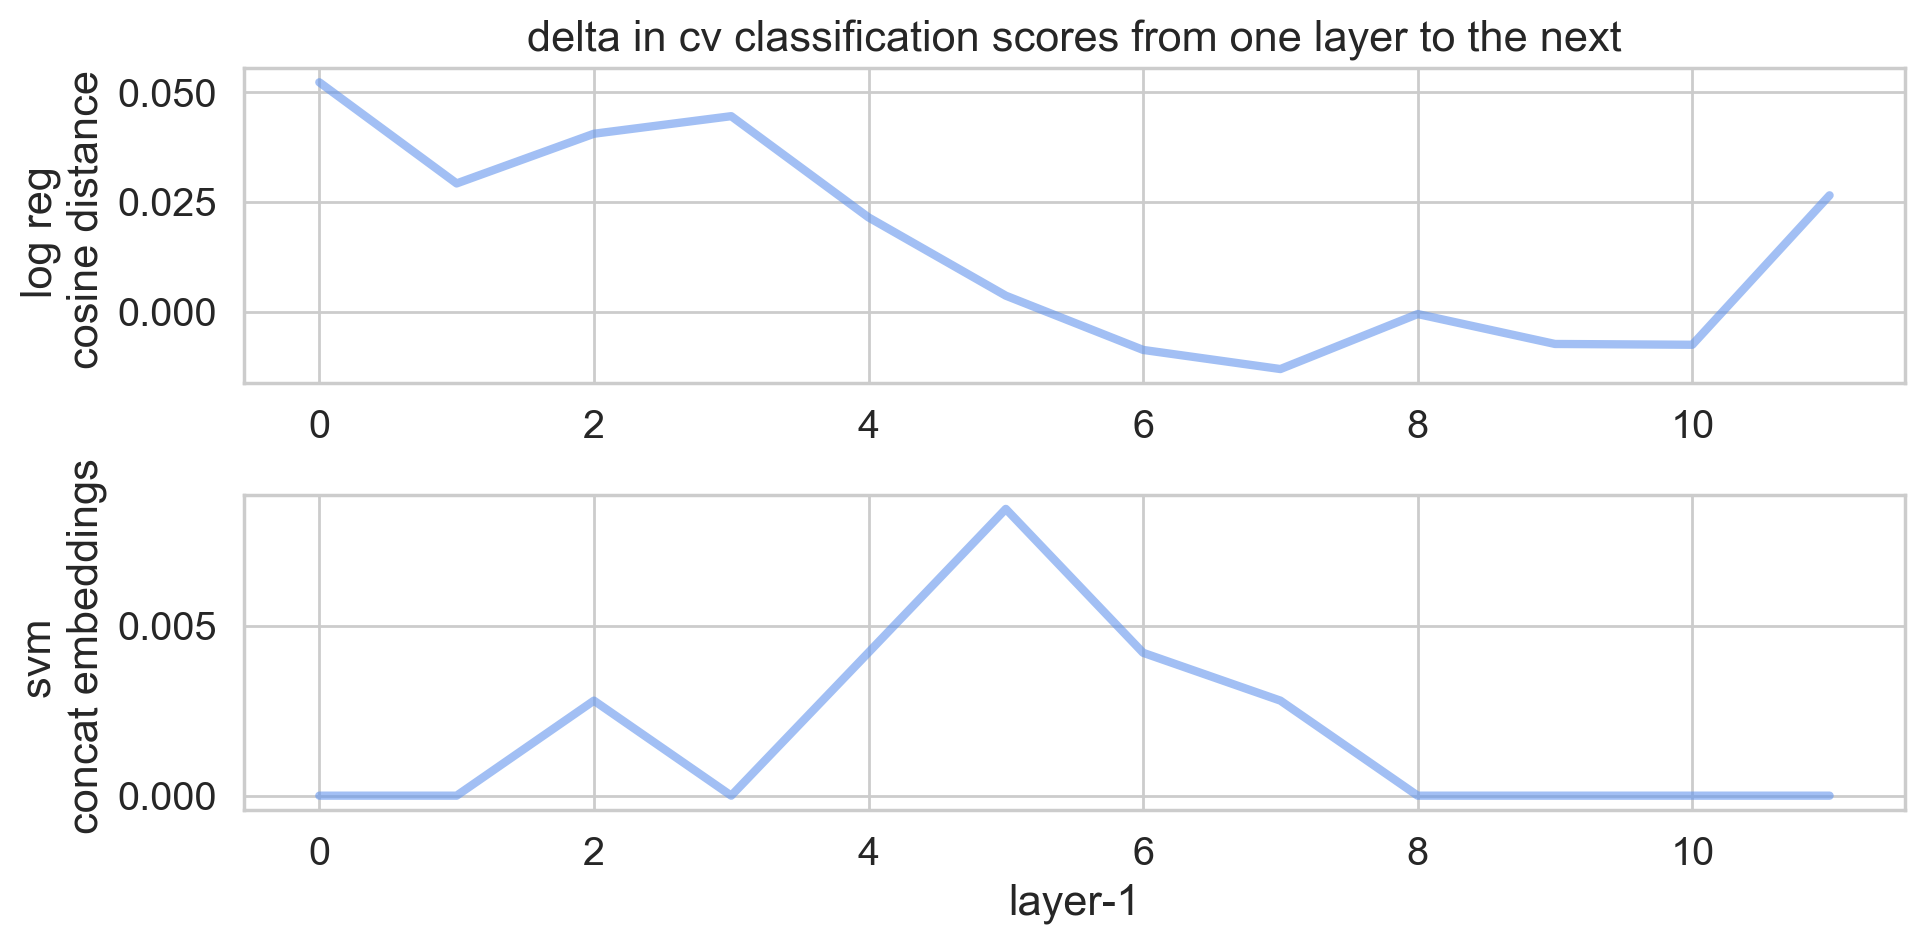

In [ ]:
sns.set(style='whitegrid',font_scale=1.3)
fig,ax = plt.subplots(2,1,figsize=(10,5))

ax[0].plot(np.diff(clf_results['score_cosd_logreg'].values),
           color='cornflowerblue',
           alpha=0.6,
           linewidth=3
          )
ax[0].set_title('delta in cv classification scores from one layer to the next')
ax[0].set_ylabel('log reg \n cosine distance')



ax[1].plot(np.diff(clf_results['score_embed_svm'].values),
           color='cornflowerblue',
           alpha=0.6,
           linewidth=3
          )
ax[1].set_ylabel('svm \n concat embeddings')

ax[1].set_xlabel('layer-1')


fig.tight_layout()